In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster, mixture
import validation_lib
import transform_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    "po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    "po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.21,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_di)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.001002484096621776, n_outlier: 136

Total error rate: 0.0017007681126270041
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000716     0.003261   0.002664   0.002184   0.000568 0.000812

Precision (TP / (TP + FP)): 0.9979576772594629
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999106     0.995181   0.995611   0.998945    0.99947 0.999248

Recall / TPR (TP / (TP + FN)): 0.9967568434804532
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998486     0.994174   0.996092   0.994954    0.99883 0.998168

Specificity / TNR (TN / (TN + FP)): 0.9990315209111683
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999622     0.997872   0.997924   0.999414   0.999734 0.999656

Accuracy ((TP + TN) / (P + N)): 0.998299231887373
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999284     0.996739   0.997336   0.997816   0.999432 0.999188

Balanced Accuracy (Sp

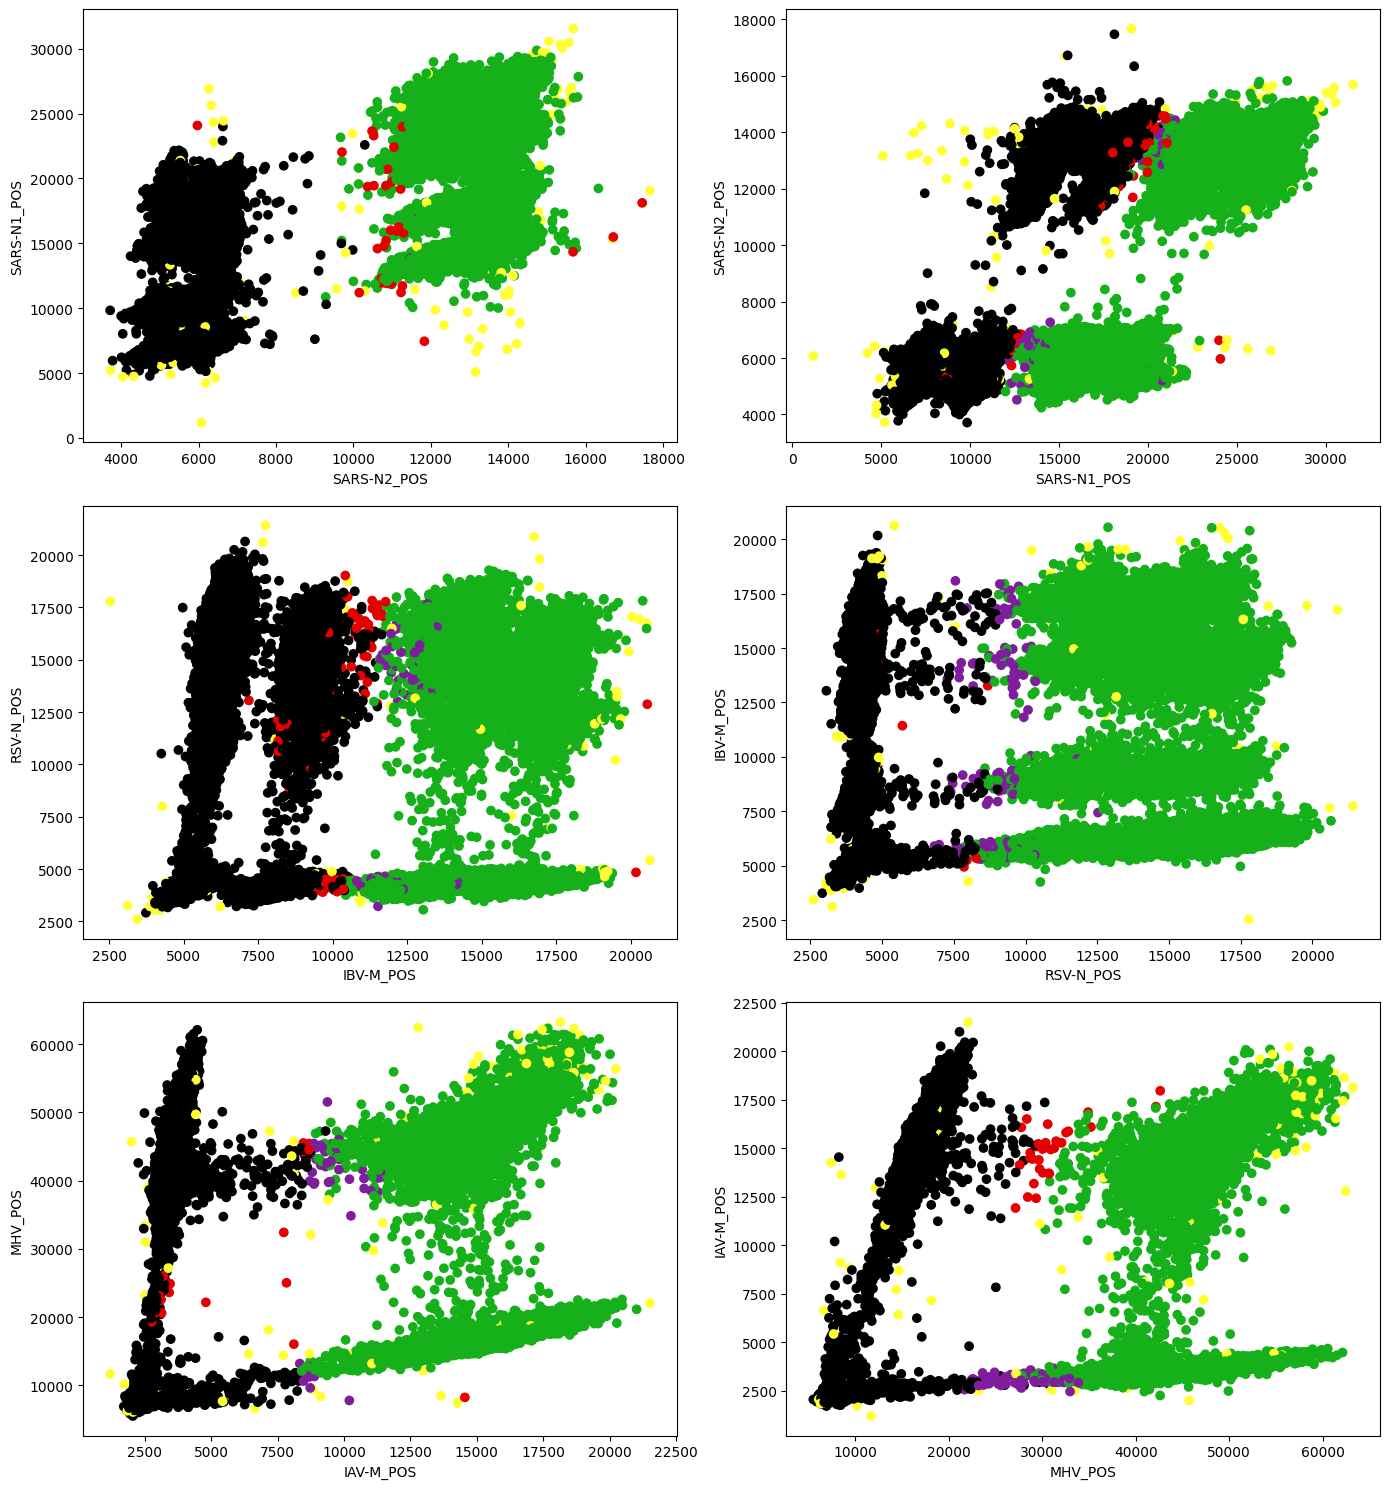

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
mask = decision.X_no_neg_mask

validation_lib.validate_labels(df_di.iloc[mask,:], df_decision.iloc[mask,:])

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

### Error inspection

print only cluster with missclassifications

ic| cluster: 92, dim: 'IAV-M_POS', n_cluster - n_true: 1


ic| cluster: 92, dim: 'MHV_POS', n_cluster - n_true: 25
ic| cluster: 96, dim: 'MHV_POS', n_cluster - n_true: 4
ic| cluster: 101, dim: 'MHV_POS', n_cluster - n_true: 70
ic| cluster: 1, dim: 'SARS-N1_POS', n_cluster - n_true: 10
ic| cluster: 23, dim: 'SARS-N1_POS', n_cluster - n_true: 9
ic| cluster: 27, dim: 'SARS-N1_POS', n_cluster - n_true: 17
ic| cluster: 45, dim: 'SARS-N1_POS', n_cluster - n_true: 70
ic| cluster: 84, dim: 'SARS-N1_POS', n_cluster - n_true: 5
ic| cluster: 86, dim: 'SARS-N1_POS', n_cluster - n_true: 49
ic| cluster: 92, dim: 'SARS-N1_POS', n_cluster - n_true: 50
ic| cluster: 100, dim: 'SARS-N1_POS', n_cluster - n_true: 67
ic| cluster: 101, dim: 'SARS-N1_POS', n_cluster - n_true: 18
ic| cluster: 27, dim: 'SARS-N2_POS', n_cluster - n_true: 10
ic| cluster: 92, dim: 'SARS-N2_POS', n_cluster - n_true: 23
ic| cluster: 100, dim: 'SARS-N2_POS', n_cluster - n_true: 17
ic| cluster: 101, dim: 'SARS-N2_POS', n_cluster - n_true: 9
ic| cluster: 27, dim: 'IBV-M_POS', n_cluster - n_tru

(Partially) falsely classified clusters [  1  23  27  43  45  84  86  92  96  97 100 101]


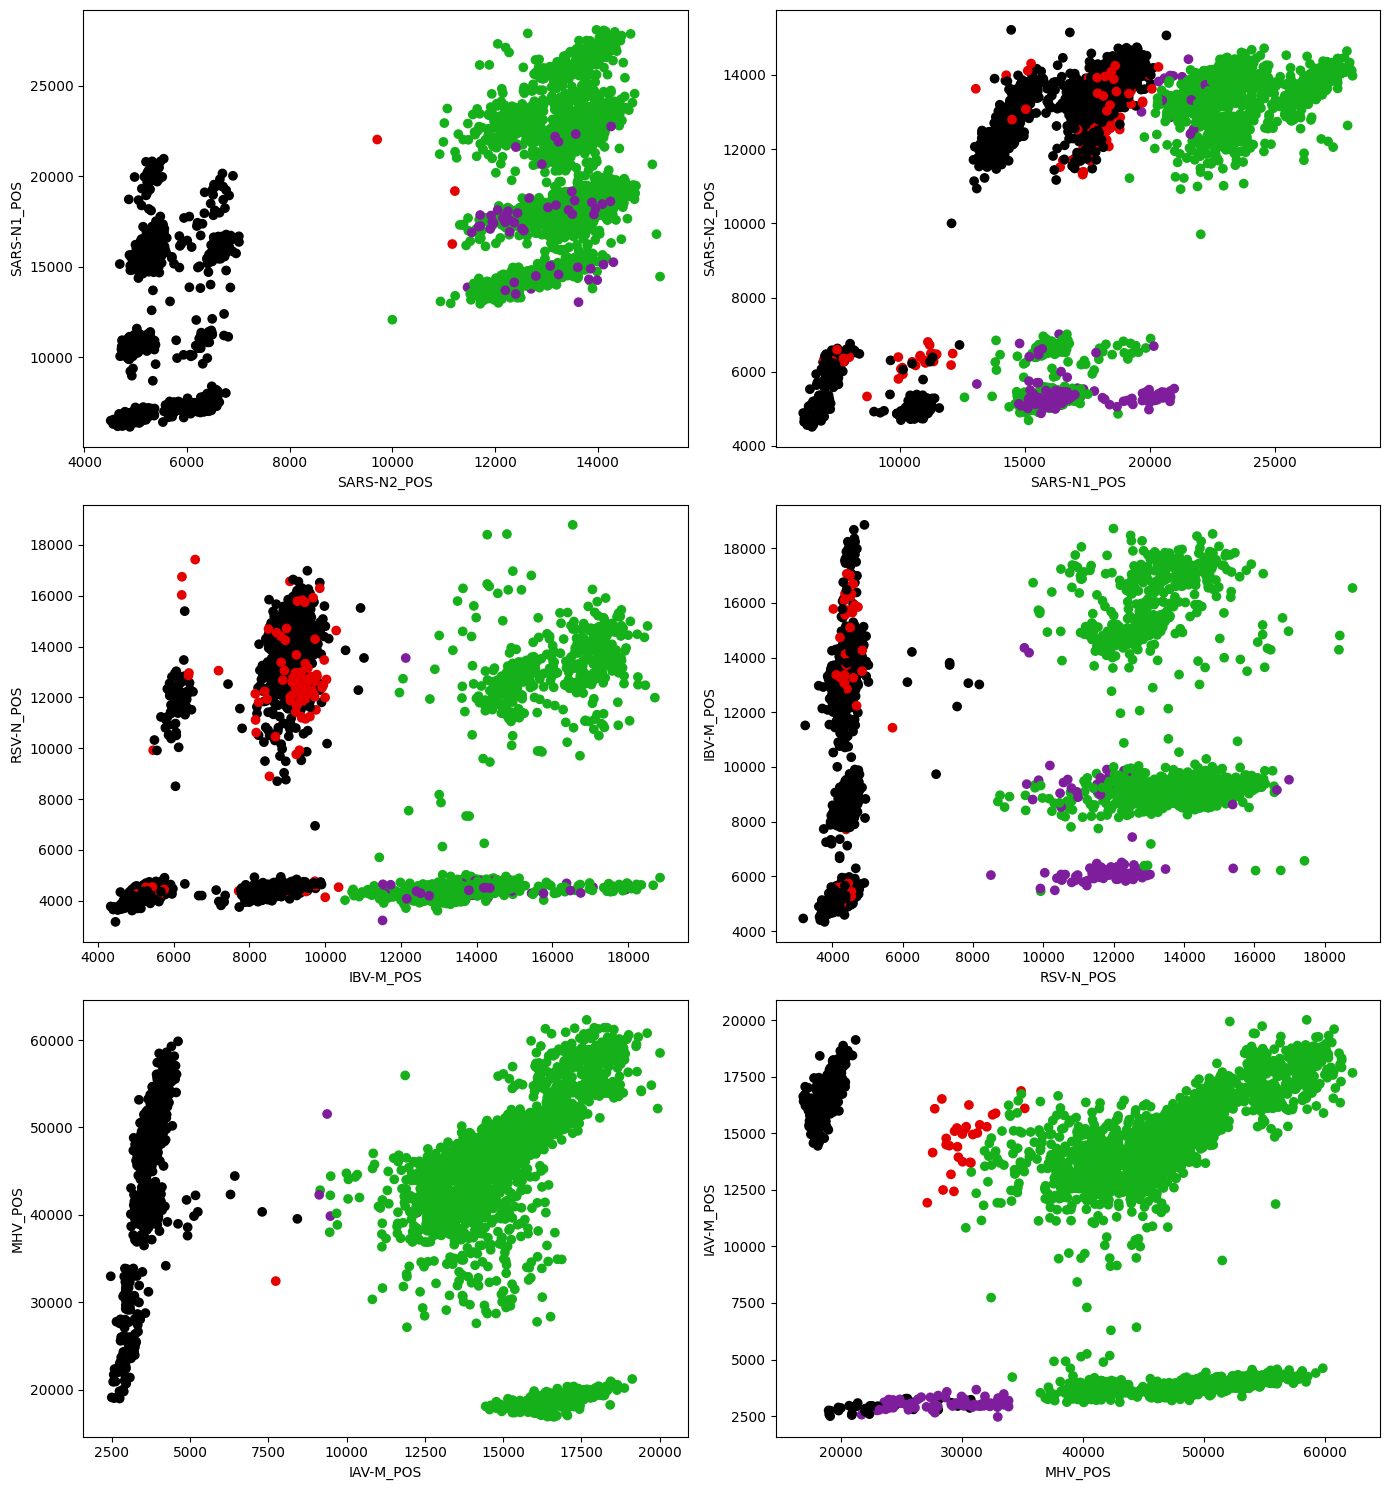

In [6]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(cluster_mask=decision.cluster_no_neg_masks,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  mask=decision.X_no_neg_mask,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           cluster_masks=decision.cluster_no_neg_masks,
                                                                                                           false_clusters=false_clusters,
                                                                                                           all_mask=decision.X_no_neg_mask)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)